# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

***Note to reviewer:*** All the *answers*, *observations*, and *questions* were **based exclusively on the simulation** and not on the project description or code.

- The Smartcab is not moving at all during the simulation.
- The rewards it is receiving are defined by the particular situations (states) that it happens to find itself in. Even though the Smartcab is not itself moving, the rest of the cars in the simulation are. In addition, the traffic lights are also active. So, the Smartcab **states** are changing despite its immobility. 
- The agent is idling all the time, but the rewards change to reflect if this is the right thing to do in the particular state. In other words, what is the utility of the Smartcab action in this state. For example, `"Agent idled at a green light with no oncoming traffic. (rewarded -5.69)"` or `"Agent properly idled at a red light. (rewarded 2.79)"`.

***Further observations:***

- The cars move in a stepwise fashion, that is, not *continuously*, from intersection to intersection.
- The cars only move one intersection at a time.
- The white car seems to be the Smartcab.
- It looks like the two most important elements of the **state** are:
  - Whatever the state of motion of the Smartcab is (see question below)
  - The state of the light at the current intersection where the Smartcab is
    - **Note:** The lights are **not** visible on the simulation!
  - The oncoming traffic one intersection away in the directions to the right, to the left, and straight ahead, with respect to the Smartcab
- It appears that the **actions** of the Smartcab will be:
  - Go straight
  - Turn left
  - Turn right
  - Idle
  - *Stop (?)*

***Questions (open in italics, answers underneath):***

- In what order do the cars move. Does it matter?
  - Lights are green exclusively NS or EW, so that constrains motion significantly (only right turns allowed on red)
  - At each step, the dummy agents perform a legal action or stay, if there isn't any
  - There are at most 4 cars at an intersection, counting the cab
  - The order doesn't matter because every car at an intersection can either make a safe move or idle in a single time step and its options don't change until the next time step **This might not be correct?**
- *What if the cars move **one on top of the other** if, say, the cab turns right and the oncoming car turns left? Some necessary assumptions have to be checked:*
  - *There has to be avoidance code in the source files*
  - *If only one car can be on one side of an intersection, that has to be ensured in the code*
  - *If the cab has to make sure that it doesn't end up on top of another agent then:
    - *There the environment/simulation has to be able to report this condition and penalized it*
    - *The agent has to move last or the dummy agents should be avoiding this somehow*
- What is a state and is it possible to ensure no accidents in the next state by evaluating the current state only (Markov property)?
  - Yes, the environment is simplified enough that all accidents can be prevented
  - The current state information is sufficient for achieving *perfect safety*
  - Because both the next waypoint and the remaning time are available to the cab, it should be able to learn to be efficient and reliable
  - The deadline is set at 5 times the number of intersections from start location to destination, so it makes sense to go for perfect safety first
- What is **oncoming** traffic as information about the state? How does the agent use it to avoid an accident?
  - 'Oncoming' traffic is a car that comes from across the intersection from the cab. This is to be differentiated from 'left' and 'right'
  - The agents are provided with information about the intended direction of each of the up to three other agents at the same intersection
- Is the Smartcab always "on", that is, is its engine always running? More generally, what are the states of motion for the Smarcab (e.g. driving, idling, stopped, etc)?
  - Engine doesn't matter
  - Actions are *none, left, right, forward*
  - *None* means the car is stopped/idling
- Does the Smartcab have to explicitly **idle** or is idle the default when no driving action is specified?
  - *None* is explicitly returned
- Does the Smartcab have to explicitly **stop** or is stopped the default when no driving action is specified?
  - Each agent either moves to the next intersection (forward, left, or right) or stays idle
  - No need for *stop* in this setup
- How are **cab positions and destinations** expressed?
  - x, y coordinates of the environment grid
- Does the grid **wrap around**? If not, can the Smartcab **exit** out of the grid? If yes, what happens to the Smartcab if it does?
  - Yes, the world wraps around and distances are correctly computed by the simulator
  - The cab never exits, because the world is *circular*
- Is the intersection with the Udacity logo significant in any way? Is that, perhaps, the Smartcab destination?
  - The Udacity logo seems to indicate the destination for the cab
- Can, and, if yes, how, can the Smartcab tell if an oncoming vehicle will go straight or make a turn?
  - inputs['oncoming'] will give the intended driving direction, `None` if no car

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

***Note to reviewer:*** There wasn't a `/logs/` folder, so I created it.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

***`agent.py`***

***Note to reviewer:*** Defaults in square brackets.

***Environment/Agent Flags***
- `verbose` [*`False`*]: Print debugging information about environment/agent events.
- `num_dummies` [*`100`*]: Number of other cars in the environment.
- `grid_size` [*`(8, 6)`*]: Size of the city.
- `learning` [*`False`*] (Agent): Turn on/off Q-learning. When off, agent takes random actions.
- `epsilon` [*`1.0`*] (Agent): A coefficient of exploration(-exploitation), probability of taking a random action when learning. Epsilon value of 1.0 means full exploration (that is, random action).
- `alpha` [*`0.5`*] (Agent): Learning rate for value iteration.
- `enforce_deadline` [*`False`*] (Env/Agent): Environment has one primary agent to monitor. Flag turns on deadline enforcement for the primary agent.

***Simulation Flags***
- `update_delay` [*`2.0`*]: Rate of simulation GUI update.
- `display` [*`True`*]: Whether GUI is on or off.
- `log_metrics` [*`False`*]: Whether to log metrics to file in `/logs/`.
- `optimized` [*`False`*]: Whether the logs contain optimized Q-learning parameters.
- `tolerance` [*`0.05`*]: Threshold of exploration factor `epsilon` at which to start testing. 
- `n_test` [*`0`*]: Number of testing trials.

***`environment.py`***

The `update` method of the `LearningAgent` or `DummyAgent` subclasses of the `Agent` class calls the `act` method of the `Environment` class to perform the an action. The full driving environment logic is implemented in this method, including the valid actions for the agents and the type of accidents that may occur as a result of them. The relevant state parameters and metrics are updated at every call to `act`, including agent violations, penalties, and rewards.

***`simulator.py`***

The `Simulator` class has two output modes, GUI and text. The GUI output is done in the `render` method and the text output is done in the `render_text` method. The latter is unconditional while the former is controlled by the `display` flag. The latter ouputs to the console/terminal, the former updates a Pygame graphic environment.

***`planner.py`***

The `next_waypoint` method of the `RoutePlanner` considers the **East-West** direction *first* and the **North-South** direction afterwards. Specifically, it computes the cardinality of the destination coordinates, relative to the current location, along both EW and NS directions.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust the following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simulation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


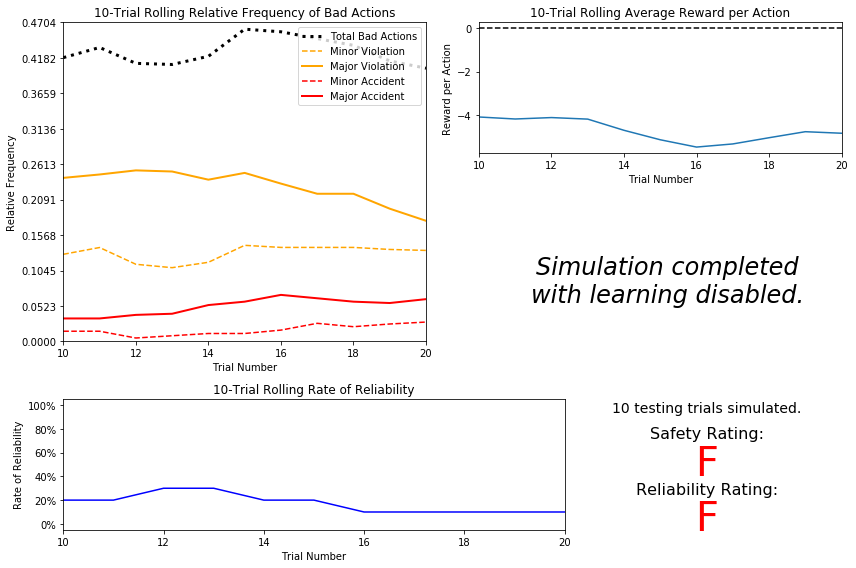

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

1. The random-action Basic Driving Agent performs badly and is neigher safe, nor reliable.
2. The agent makes bad decisions around 40% of the time. Since it acts randomly, the rate of bad decision is likely more dependent on the environmental parameters than it's driving. For example, if we had fewer dummy agents (i.e. other cars), there would be fewer accidents, and the above percentage would be lower.
3. Out of 20 trials, the agent only makes the destination in time 3 times. Again, this is entirely by chance and depends more on the environment setup than the driving of the agent.
4. The rate of reliability makes no sense for a randomly driving agent. The agent is not doing anything to achieve a particular goal.
5. The outcome of results does not change significantly with the increase of the number of trials. This is to be expected, as there is no behavioral change to cause a significant departure.
6. The agent is heavily penalized for its actions. There is a high negative cumulative reward at the end of each trial.
7. There is no distinguishable difference in performance between training and testing trials. Again, in the case of the Basic Driving Agent, there is no reason to expect any difference.


-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

1. The features I would use to represent a state are **(light, waypoint, *deadline*, left_fwd, oncoming_fwd_rt)**.
2. The first three features are copied verbatim from the available state information. 
  1. **deadline** is included to investigate the ability of the Q-learning agent to acquire a *"sense of urgency"*. **deadline** is not very informative to the agent except that it might make it more likely to follow the **waypoint**. However, an integer feature with potentially hundreds of values can negatively impact the state space. (See discussion in next answer box.)
3. **left_fwd** *(boolean)* is computed from the inputs and represents a car coming from the left of the cab and going forward. This is important to prevent accidents when the cab is turning right on a red light.
4. **oncoming_fwd_rt** *(boolean)* is computed from hte inputs and represents a car coming from across the intersection from the cab and is going forward or turning right. This is important to prevent accidents when the cab is turning left (on a green light).
5. Safety features: **light**, **left_fwd**, and **oncoming_fwd_rt**.
6. Efficiency/reliability features: **waypoint**, and _**deadline**_.
7. Any other traffic features are unnecessary due to the exclusivity of the lights: since either the NS or the EW direction is allowed by the lights, but never both, a lot of other complicated right-of-way considerations are rendered irrelevant (e.g. a 3-way or 4-way stop). In fact, the environment and simulator are simplified to the point that they are unable to encode these more complicated real-world driving situations.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

1. The size of the state space defined as **(light, waypoint, left_fwd, oncoming_fwd_rt)**, i.e. without **deadline**, is $|S| = 2\times3\times2\times2 = 24$, since **light** ('red', 'green'), **left_fwd**, and **oncoming_fwd_rt** are binary, and **waypoint** is ternary ('left', 'right', 'forward'). This is a modest space size and the cab should be able to learn optimal actions for each one state within a reasonable number of training trials.
2. **deadline** is an integer value and is currently being set to *5 times the number of intersections from the start location to the destination*. For an 8 x 6 world, considering Manhattan distance, this makes 240. If **deadline** is used in the definition of the state, the state space size will grow significantly to $10\times{24}^2$. This, however, as mentioned above, not only does not inform the cab of the optimal action, but also makes the space too big to learn optimal actions for. Two states that are the same except for the value of **deadline** are still going to have the same optimal action. The only possible advantage of including **deadline** or some derivative of it is to make the cab less likely to steer away from the provided **waypoint**. 
3. The **waypoint** is the optimal action *if it is valid from a safety point of view*. An agent that always follows the **waypoint** and idles otherwise is likely to reach the destination in time. However, idling on a green light incurs a *blocking traffic* violation, so there is some incentive for the cab to always make a driving motion on a green light, even if it is different from the **waypoint**. This, of course, takes it away from the direction to the destination and is likely to delay reaching the destination, risking the ultimate penalty of a *failed trip*.
4. Since the cab agent is only given **deadline**, the number of remaining time steps it has left, to compute an *urgency* derivative, it needs to keep a counter of the steps it has already taken. Thus, a new feature, **urgent**, can be computed indicating the fraction of the time that is left realtive to the time spent driving so far: $\geq75\%$, $<75\%$, $<50\%$, and $<25\%$. This gives us a feature with fewer values and keeps the space size still manageable, at $24\times4=96$. 

**Note:** For the initial implementation of the Q-learning agent, the state will be defined without **deadline** or its derivative **urgent** to see how the cab is doing without being "rushed". Depending on the results, I might add this extra feature to the state description at a later stage.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

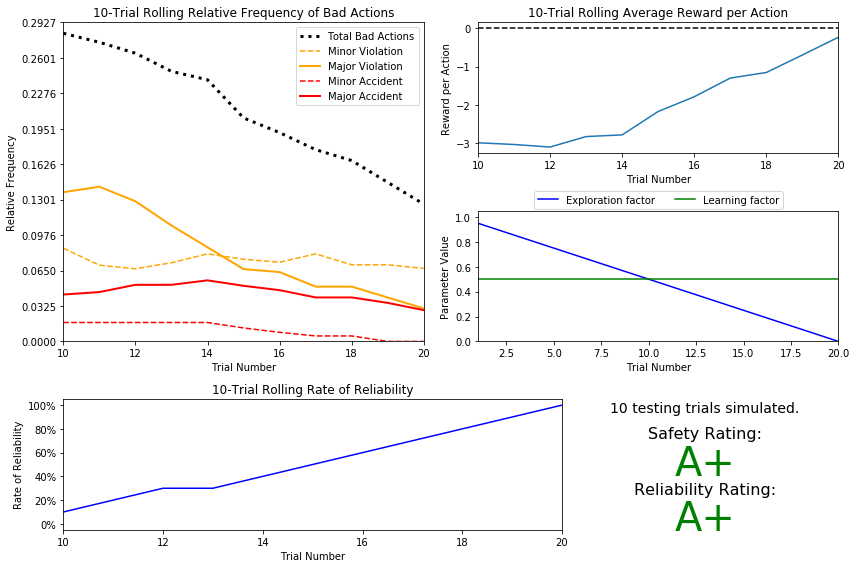

In [7]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

1. The default Q-learning agent learns well and its performance is excellent **(A+, A+)**. The cab is both **safe** and **reliable**. There is little resemblance to the simple random agent which earned **(F, F)**.
2. The features selected for the state representation (namely, *(light, waypoint, left_fwd, oncoming_fwd_rt)*) are adequate for Q-learning and there doesn't seem to be any need to add any. During testing, the cab commits no traffic violations and reaches the destination on time every time.
3. Examining the Q-table shows that the agent has encountered *23* out of all *24* possible states and has learned important driving rules (elements of the *optimal driving policy*):
  1. No running a red light.
  2. No right turn on red when there is a car coming from the left.
  3. No left turn if there is an oncoming car turning right or going forward.
  4. No idling on green light.
4. The feature selection is *minimal but sufficient*, resulting in **fast learning times** and **perfect safety and reliability**. From the Q-table it is evident that the agent is **close to optimal**.
5. From the Q-table it looks like the agent hasn't learned to follow the waypoint in most green-light states. This is probably due to:
  1. The agent's inability to infer that when it has a green light, cross traffic has red and it doesn't matter.
  2. Lower or no penalties for green-light states.
  3. Tie-breaking behavior for actions with equal Q-values.
6. At the same time, the output shows that the agent follows the waypoint most of the time, and reaches the destination within a large time margin.
7. This agent has a linear decaying $\epsilon$-function which is clearly reflected in the parameters panel. The agent took about 20 training trials before testing, which is consistent with the linear decay. However, it took *only 11 trials* for the cab to start consistently reaching the destination on time.
8. As the number of training trials increased above Trial 11, the cab's safety dropped monotonically and steeply, while the average reward per action increased monotonically.
9. Interestingly, the results don't change if *"future rewards"* are included, proving the point that they can be excluded. More on this in the Answer to Question 9.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

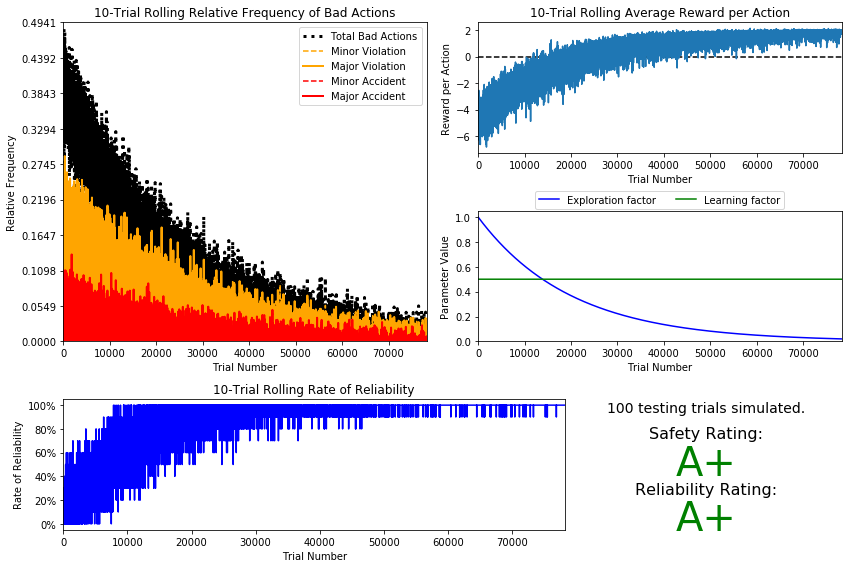

In [3]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

1. Since the default Q-learning agent has already achieved **perfect safety and reliability** with very reasonable learning time, this part will be first an *exploration* of what might have to be optimized (e.g. stress testing).
2. Does the **(A+, A+)** score hold over a much larger number of tests? If not, can the cab be optimized to be consistently perfect?
  1. **Interesting:** In 100 test trials, safety dropped to **F** due to three major accidents, and reliability dropped to **A** due to 3 failures to reach the destination on time. There is nothing learnt that is obviously wrong. And, unless there is a bug in the code somewhere, during testing the agent always takes the hightest-Q action and never a random one. Rerunning a few times, the safety score remains at **F** even though the reliability score goes back to **A+**. This is to be expected as a single major violation resulting in an accident drops earns an **F**.
  2. What is the violation? There are only Type 3 and Type 4 violations, that is, accidents. 
    1. Type 3 can happen only if the cab attempts to turn right on red when there is traffic from the left. Both states that govern this behavior ('red', 'right', True, \*) have highest Q-value on action **None**. What could be causing these violations??? Looking at the other 'red' states yields the first culprit:
    ```
    ('red', 'left', True, True)
     -- forward : 0.00
     -- None : 0.00
     -- right : -9.90
     -- left : 0.00
    ```
    As a reminder, the state representation is the tuple *(light, waypoint, left_fwd, oncoming_fwd_rt)*. The tie-breaker will cause the cab to occasionally run the red light! This is clearly a learning problem, due to lack of discrimination between actions in this state. Before increasing the number of learning trials (by adjusting $\epsilon$), I need to look at other similar cases. And here is the next one:
    ```
    ('red', 'forward', True, True)
     -- forward : -20.27
     -- None : 0.00
     -- right : 0.00
     -- left : 0.00
    ```
    This will cause the cab to randomly run a red light due to the action tie-breaker. No other red-light states have this problem. Looking for multiple equal Q-value cases among the green-light states yields some odd cases, none of which will result in an accident *(assuming that dummy agents won't turn left on green when the cab is going forward or right, which is explicitly coded in the `DummyAgent` class)*:
    ```
    ('green', 'forward', True, True)
     -- forward : 0.00
     -- None : 0.00
     -- right : 0.37
     -- left : 0.62
    ```
    ```
    ('green', 'left', True, True)
     -- forward : 0.00
     -- None : 0.00
     -- right : 0.00
     -- left : 1.75
    ```
    ```
    ('green', 'right', True, True)
     -- forward : 0.58
     -- None : 0.00
     -- right : 0.00
     -- left : 0.00
    ```
    ```
    ('green', 'left', True, False)
     -- forward : 0.35
     -- None : 0.00
     -- right : 0.76
     -- left : 0.00
    ```
    2. Type 4 can occur only on running a red light and running into *cross traffic*. Since we already have two culprits to explain this, no further exploration is needed at this time. If, however, learning over more trials doesn't remove the action ties on red-light states, there might be a need to add a feature or two. *Clearly, the feedback from the environment is not captured successfully by losing too much information in the projection on the the feature representation.*
    3. Incidentally, all these cases randomize the behavior of the agent and increase the chance that the cab doesn't reach the destination on time. So, learning to discriminate among "action options" may shore up the occasional problems in realiability.
  3. We need better learning.
    1. The simplest way to cause more learning is to make $\epsilon$ decay more slowly. Setting the decay formula to $\epsilon_{t+1}=\epsilon_t-0.03$, which cause about 32 training trials before testing, doesn't eliminate the dangerous action ties. Neither does $\epsilon_{t+1}=\epsilon_t-0.02$ (48 training trials). At least not consistently.
    2. There might be merit in having $\epsilon$ decay *sublinearly*. This will decrease the proportion of *exploration* more sharply. The formula $\epsilon=0.95^t$ eliminates the dangerous ties more often, but again not consistently. The learning graphs stop being monotinic, and the safety rating bounces between **A+** and **F**. A deeper exploration of $\epsilon$-decay functions might be in order, but there are more powerful tools to explore first: varying the learning rate $\alpha$ and adding another feature.
    3. Increasing the learning rate to $\alpha=0.65$ gives an inconsistent boost of the safety consistency across multiple learning runs.
    4. Changing the feature representation to *(light, waypoint, left_fwd_lt, oncoming_fwd_rt, right_any)* does not improve things substantially ($\epsilon=0.95^t$, $\alpha=0.65$, $77$ training trials). Q-value tied actions still remain, causing accidents.
    5. Changing the feature representation to *(light, waypoint, left, oncoming, right)* with parameters  ($\epsilon=0.95^t$, $\alpha=0.65$, $77$ training trials).
    6. With this many degrees of freedom (features, Q-learning parameters, number of trials), manual selection and optimization becomes infeasible. A more systematic and automated exploration of the parameter space is required to identify large-scale patterns and trends.
    7. Another way is to dramatically increase the learning trials. We do this in the next section.
  4. We need more training trials.
    1. We saw that the biggest problem with the cab were Q-value tied actions for a state, coupled with the randomized tiebreak strategy adopted in the cab code. Here we devise a **brute force** learning with a with non-derivative feature state representation and a great number of training trials to prove to ourselves that, with sufficient learning, this problem can be alleviated.
    2. The new, and final, representation of the state is as follows:
    ```
    (light, waypoint, left, oncoming, right)
    ```
    These features are obtained as follows:
    ```
    (inputs['light'], waypoint, inputs['left'], inputs['oncoming'], inputs['right'])
    ```
    These features are non-derivative, allowing the agent to learn exactly what matters and what doesn't, without human feature design. The cardinalities of the features are as follows: **(2, 3, 4, 4, 4)**, which makes for a state space with size $|S| = 2\times3\times4\times4\times4 = 384$. This space is significantly larger than the one used for the default agent. Correspondingly, it needs a lot more learning examples, so that each state can be visited sufficiently frequently to learn the optimal action for it.
    3. The new learning parameters are as follows: ($\epsilon=0.99995^t$, $\alpha=0.65$, $tolerance=0.02$). This results in **78K** training trials which took around *3.5 hours on a Macbook (2.8 GHz Intel Core i7, 16 GB 1600 MHz DDR3)*. For a small project, this might border on *unreasonable* training time, but it is adequate for a technology with human lives and billion-dollar lawsuits at stake.
    4. The number of trials *might or might not be excessive*. By some metrics the cab learns to drive well after about a third of the trials, but the mean number of violations and accidents continues to decrease monotonically for the rest of the trials.
    5. On *100 test trials*, the cab performs safely and reliably, earning **(A+, A+)**. Since the number of bad actions have not dropped to zero by the end of learning, and are still fluctuating, it is likely that on a larger number of test trials its score might drop again. However, there is now good reason to expect that sufficient extra learning may close the gap again.
    6. Looking at the Q-table file, **we no longer see Q-value tied actions for any of the states**. A brief examination of the table shows that the Q-values for each state show a clearly dominating single action, with correct behavior on red lights and a preference to follow the waypoint.
    7. **Remark:** It appears that **deadline** is an unnecessary feature, as the cab learned both safety and reliability with very consistent scores.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward and know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different from what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

***I. Optimal Policy***

The optimal driving policy emerges from the work so far. As a reminder, the state representation for the optimized Q-learning agent is *(light, waypoint, left, oncoming, right)*. The values are $light\in\{'red', 'green'\}$, $waypoint\in\{'right', 'forward', 'left'\}$, $left\in\{None, 'right', 'forward', 'left'\}$, $oncoming\in\{None, 'right', 'forward', 'left'\}$, and $right\in\{None, 'right', 'forward', 'left'\}$.

1. **RULE 1:** On red, unless turning right, idle.
  1. **State representation:** $('red',\overline{'right'},\ast,\ast,\ast)$. 
  2. **Action Q-values:** `None`, equivalent to *idling*, should dominate.
2. **RULE 2:** On red, if turning right, turn right only if there is no car from the left, going forward.
  1. **State representation:** $('red', 'right',\overline{'forward'},\ast,\ast)$.
  2. **Action Q-values:** `'right'` should dominate.
3. **RULE 3:** On green, unless turning left, go.
  1. **State representation:** $('green',\overline{'left'},\ast,\ast,\ast)$
  2. **Action Q-values:** `'left'` should be dominated and none of the other actions should be tied.
4. **RULE 4:** On green, if turning left, turn left only if there is no oncoming car turning right or going forward.
  1. **State representation:** $('green', 'left',\ast,(None|'left'),\ast)$.
  2. **Action Q-values:** `'left'` should dominate.
5. **RULE 5:** When it is a valid move, follow the waypoint.


***II. Correct Policy Learning***
  
Since showing all 384 state Q-value dictionaries would make this unreadable, below are some samples of learning the above rules. Arrows show the relevant Q-values.

1. **RULE 1**

```
('red', 'left', 'forward', 'forward', 'forward')
 -- forward : -40.25
 -- None : 2.36           <==
 -- right : -20.19
 -- left : -40.23
```
```
('red', 'left', 'right', 'left', 'forward')
 -- forward : -39.69
 -- None : 2.00           <==
 -- right : 1.15
 -- left : -39.53
```
```
('red', 'left', 'right', 'forward', None)
 -- forward : -9.42
 -- None : 1.94           <==
 -- right : 0.78
 -- left : -10.28
```
2. **RULE 2**

```
('red', 'right', 'forward', 'left', None)
 -- forward : -40.62
 -- None : 1.31           <==
 -- right : -20.30
 -- left : -39.46
```
```
('red', 'right', 'left', 'forward', 'forward')
 -- forward : -40.30
 -- None : 0.86
 -- right : 2.38          <==
 -- left : -40.18
```
```
('red', 'right', 'right', 'forward', 'forward')
 -- forward : -39.95
 -- None : 0.96
 -- right : 1.57          <==
 -- left : -40.01
```
3. **RULE 3**

```
('green', 'right', 'right', 'forward', 'left')
 -- forward : 0.65
 -- None : -5.15
 -- right : 1.68          <==
 -- left : 1.11
```
```
('green', 'right', 'left', 'left', 'right')
 -- forward : 0.92
 -- None : -5.53
 -- right : 1.70          <==
 -- left : 0.90
```
```
('green', 'forward', 'right', 'forward', 'forward')
 -- forward : 1.46        <==
 -- None : -5.30
 -- right : 1.09
 -- left : 0.74
```
4. **RULE 4**

```
('green', 'left', 'forward', None, 'forward')
 -- forward : 0.45
 -- None : -4.76
 -- right : 0.47
 -- left : 2.42           <==
```
```
('green', 'left', None, 'left', None)
 -- forward : 0.54
 -- None : -4.85
 -- right : 0.34
 -- left : 2.29           <==
```
```
('green', 'left', 'right', None, 'right')
 -- forward : 0.94
 -- None : -4.92
 -- right : 0.89
 -- left : 1.93           <==
```
5. **RULE 5**

```
('red', 'right', 'right', 'left', 'right')
 -- forward : -10.40
 -- None : 0.48
 -- right : 1.67          <==
 -- left : -9.50
```
```
('green', 'forward', 'left', 'forward', None)
 -- forward : 1.59        <==
 -- None : -5.07
 -- right : 0.87
 -- left : 0.41
```
```
('green', 'right', 'left', None, 'right')
 -- forward : 0.87
 -- None : -4.40
 -- right : 1.79          <==
 -- left : 1.19
```

***III. Incorrect Policy Learning***

Unfortunately **RULE 4** seems to have been learned wrong because _the cab **consistently** prefers to turn left regardless of what the oncoming car is doing_. I am surprised that the agent is not getting into more accidents. Perhaps the simulation works out so that there aren't that many occurrences of the case where the cab needs to turn left and there is an oncoming car going forward or turning right. I don't see why this might be likely, but if it is so, it might explain why the cab has not learned the correct behavior. *It would be interesting to run a training round recording the number of times the agent has visited each state.*
  
1. **RULE 4**

```
('green', 'left', 'left', 'right', 'forward')
 -- forward : 0.87
 -- None : -5.14
 -- right : 0.57
 -- left : 2.40
```
```
('green', 'left', 'left', 'right', 'right')
 -- forward : 0.61
 -- None : -5.00
 -- right : 1.00
 -- left : 2.57
```
```
('green', 'left', 'forward', 'forward', 'left')
 -- forward : 0.94
 -- None : -5.37
 -- right : 0.66
 -- left : 1.86
```


***CORRECTION***

I found the missing piece of the puzzle! Read the code, Watson :D

The agent has learnt perfectly, but the definition of **RULE 4** cannot be reproduced by the Smartcar environment and simulation because it would require a much more complex representation and motion follow-through. Instead, an important assumption has been made: **if the cab should turn left, but there is an oncoming car turning right or going straight, the cab would just wait for the other car before completing the left turn**. The last few lines of the code snippet from `environment.py` below are the relevant ones. The comments are pretty explicit, but it took me this long to understand what they meant. Duh!

```python
        # Agent wants to drive forward:
        if action == 'forward':
            if light != 'green': # Running red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
        
        # Agent wants to drive left:
        elif action == 'left':
            if light != 'green': # Running a red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
                elif inputs['oncoming'] == 'right': # Oncoming car turning right
                    violation = 4 # Accident
            else: # Green light
                heading = (heading[1], -heading[0]) # Valid move. We assume the cab will wait for the lane to
                                                    # be clear on a green light, before taking the left turn.
```

If the environment were to not make this assumption, the complexity of the following right-of-way rules at an intersection would increase considerably. Even the time point would have to be fragmented to accomodate the more elaborate realization of correct driving behavior. The source code would be significantly bulkier.

***IV. Conclusion***

The agent appears for all intents and purposes to have learnt the **optimal policy** for the given driving environment. Considering the correction above, **there isn't a state that has been learnt wrong**.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

1. I tried to use future rewards, just to see what happens.
  1. First of all, there is no clear way, the way the environment and agent are set up, to have a clear measure of the Q-value of a *future* state. The only surrogate we can use is the maximum Q-value for the current state's action, which corresponds to the best action to take. Including this Q-value in the Q-learning value iteration equation *does __not__ change the learning outcome*.
  2. The agent learns to follow the waypoint. This is the only clear measure of the correct action in any state, provided the action is valid, considering that the agent is heavily penalized for not reaching the destination on time.
2. The two major reasons for excluding future rewards in the Q-learning for this project are:
  1. **Environment:** The environment is randomized upon every trial. Even though some patterns may be learned about sequences of states (which would require much deeper memory than mere Q-values), everything else - including initial location, destination, dummy agent positions and direction - is random. The agent learns about *types* of states, not particular stationary states. Any regularities about particular states will be wiped out upon randomization. Only among *types* of states may there be persistent regularies, and this is what the agent learns across training trials.
  2. **Agent:** The agent has a very limited view of the world. It sees a light and what other cars are at an intersection. There is nothing to distinguish one intersection from another. The agent is given the best driving direction, in Mangattan distance, toward the destination. The agent cannot see the destination like, say, on a map, from above. The waypoint is also a *local* piece of information. For this reason, the agent doesn't have any way to link one state to another and percolate Q-values.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.